In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
sns.set(style='whitegrid')
ROOT_EXPORT = r"data/2015-2025soybean_export"
ROOT_IMPORT = r"data/2015-2025soybean_import"
START_DATE = "2015-01-01"
END_DATE = "2025-08-31"


In [26]:
def read_export_data(root_export):
    export_dfs = []
    for file_name in os.listdir(root_export):
        if not (file_name.startswith("TradeData (") and file_name.endswith(".xlsx")):
            continue
        df = pd.read_excel(os.path.join(root_export, file_name), sheet_name=0)
        if "flowCode" in df.columns:
            df = df[df["flowCode"] == "X"]
        df = df[df["reporterISO"].isin(["ARG", "BRA", "USA"])]
        if "cmdCode" in df.columns:
            df = df[df["cmdCode"].isin([120110, 120190])]
        total_grp = df.groupby(["refYear", "refMonth", "reporterISO"]).agg(
            Total_Export_Quantity=("netWgt", "sum"),
            Total_Export_Value=("fobvalue", "sum"),
        )
        df_china = df[df["partnerISO"] == "CHN"]
        china_grp = df_china.groupby(["refYear", "refMonth", "reporterISO"]).agg(
            Export_to_China_Quantity=("netWgt", "sum"),
            Export_to_China_Value=("fobvalue", "sum"),
        )
        export_month = total_grp.join(china_grp, how="left").reset_index()
        export_month["Date"] = pd.to_datetime(
            export_month["refYear"].astype(str) + "-" + export_month["refMonth"].astype(str).str.zfill(2) + "-01"
        )
        export_dfs.append(export_month)
    export_all = pd.concat(export_dfs, ignore_index=True)
    export_pivot = export_all.pivot_table(index="Date", columns="reporterISO", values=[
        "Total_Export_Quantity",
        "Total_Export_Value",
        "Export_to_China_Quantity",
        "Export_to_China_Value",
    ], aggfunc="sum").reset_index()
    iso2prefix = {"ARG": "AR", "BRA": "BR", "USA": "US"}
    def safe_get(df, key):
        return df[key] if key in df.columns else np.nan
    out = pd.DataFrame()
    out["Date"] = export_pivot["Date"]
    for iso, prefix in iso2prefix.items():
        out[f"{prefix}_Total_Export_Q"] = safe_get(export_pivot, ("Total_Export_Quantity", iso))
        out[f"{prefix}_Total_Export_V"] = safe_get(export_pivot, ("Total_Export_Value", iso))
    for iso, prefix in iso2prefix.items():
        out[f"{prefix}_Export_China_Q"] = safe_get(export_pivot, ("Export_to_China_Quantity", iso))
        out[f"{prefix}_Export_China_V"] = safe_get(export_pivot, ("Export_to_China_Value", iso))
    return out

def read_customs_import_data(file_path):
    df = pd.read_excel(file_path)
    df = df[df["贸易伙伴名称"].isin(["美国", "巴西", "阿根廷"])].copy()
    df["数据年月"] = df["数据年月"].astype(str)
    df["Date"] = pd.to_datetime(df["数据年月"].str[:4] + "-" + df["数据年月"].str[4:6] + "-01")
    df["Import_Quantity"] = df["第一数量"]
    df["Import_Value"] = df["美元"]
    country_map = {"美国": "United States", "巴西": "Brazil", "阿根廷": "Argentina"}
    df["Country"] = df["贸易伙伴名称"].map(country_map)
    return df[["Date", "Country", "Import_Quantity", "Import_Value"]]

def read_comtrade_import_data(root_import):
    dfs = []
    for file_name in os.listdir(root_import):
        if not (file_name.startswith("TradeData (") and file_name.endswith(".xlsx")):
            continue
        df = pd.read_excel(os.path.join(root_import, file_name), sheet_name=0)
        if "flowCode" in df.columns:
            df = df[df["flowCode"] == "M"]
        df = df[df["reporterISO"] == "CHN"]
        df = df[df["partnerISO"].isin(["USA", "BRA", "ARG"])]
        if "cmdCode" in df.columns:
            df = df[df["cmdCode"].isin([120110, 120190])]
        grp = df.groupby(["refYear", "refMonth", "partnerISO"]).agg(
            Import_Quantity=("netWgt", "sum"),
            Import_Value=("cifvalue", "sum"),
        ).reset_index()
        grp["Date"] = pd.to_datetime(grp["refYear"].astype(str) + "-" + grp["refMonth"].astype(str).str.zfill(2) + "-01")
        iso2name = {"USA": "United States", "BRA": "Brazil", "ARG": "Argentina"}
        grp["Country"] = grp["partnerISO"].map(iso2name)
        dfs.append(grp[["Date", "Country", "Import_Quantity", "Import_Value"]])
    return pd.concat(dfs, ignore_index=True)

def merge_import_data(root_import):
    customs_2015 = read_customs_import_data(os.path.join(root_import, "2015 年大豆进口数据.xlsx"))
    customs_2025 = read_customs_import_data(os.path.join(root_import, "2025 年大豆进口数据.xlsx"))
    comtrade_all = read_comtrade_import_data(root_import)
    import_all = pd.concat([customs_2015, comtrade_all, customs_2025], ignore_index=True)
    pivot = import_all.pivot_table(index="Date", columns="Country", values=["Import_Quantity", "Import_Value"], aggfunc="sum").reset_index()
    def safe_get(df, key):
        return df[key] if key in df.columns else np.nan
    out = pd.DataFrame()
    out["Date"] = pivot["Date"]
    countries = [("Argentina", "AR"), ("Brazil", "BR"), ("United States", "US")]
    for country, prefix in countries:
        out[f"{prefix}_Import_Q"] = safe_get(pivot, ("Import_Quantity", country))
    for country, prefix in countries:
        out[f"{prefix}_Import_V"] = safe_get(pivot, ("Import_Value", country))
    return out

def merge_bilateral_data(export_data, import_data):
    full_dates = pd.date_range(start=START_DATE, end=END_DATE, freq="MS")
    df = pd.DataFrame({"Date": full_dates})
    df = pd.merge(df, export_data, on="Date", how="left")
    df = pd.merge(df, import_data, on="Date", how="left")
    def validate(row):
        for exp_prefix, imp_prefix in [("US", "US"), ("AR", "AR"), ("BR", "BR")]:
            exp_q = row.get(f"{exp_prefix}_Export_China_Q", np.nan)
            imp_q = row.get(f"{imp_prefix}_Import_Q", np.nan)
            if pd.notna(exp_q) and pd.notna(imp_q):
                error_rate = abs(exp_q - imp_q) / exp_q if exp_q != 0 else 0
                row[f"{exp_prefix}_Data_Error"] = 1 if error_rate > 0.05 else 0
            else:
                row[f"{exp_prefix}_Data_Error"] = np.nan
        return row
    df = df.apply(validate, axis=1)
    for exp_prefix, imp_prefix in [("US", "US"), ("AR", "AR"), ("BR", "BR")]:
        df[f"{exp_prefix}_Bilateral_Q"] = df[[f"{exp_prefix}_Export_China_Q", f"{imp_prefix}_Import_Q"]].mean(axis=1)
        df[f"{exp_prefix}_Bilateral_V"] = df[[f"{exp_prefix}_Export_China_V", f"{imp_prefix}_Import_V"]].mean(axis=1)
    return df

def supplement_china_us_tariff(bilateral_df):
    policy_phases = [
        {"start": "2015-01-01", "end": "2018-06-30", "rate": 0.03},
        {"start": "2018-07-01", "end": "2019-12-31", "rate": 0.28},
        {"start": "2020-01-01", "end": "2024-12-31", "rate": 0.03},
        {"start": "2025-01-01", "end": "2025-02-28", "rate": 0.03},
        {"start": "2025-03-01", "end": "2025-03-31", "rate": 0.13},
        {"start": "2025-04-01", "end": "2025-04-30", "rate": 0.87},
        {"start": "2025-05-01", "end": "2025-08-31", "rate": 0.13},
    ]
    bilateral_df = bilateral_df.copy()
    bilateral_df["China_US_Tariff"] = np.nan
    for phase in policy_phases:
        start_date = pd.to_datetime(phase["start"])
        end_date = pd.to_datetime(phase["end"])
        mask = (bilateral_df["Date"] >= start_date) & (bilateral_df["Date"] <= end_date)
        bilateral_df.loc[mask, "China_US_Tariff"] = phase["rate"]
    return bilateral_df

def handle_missing_values(bilateral_df):
    bilateral_df = bilateral_df.copy()
    bilateral_df["Month"] = bilateral_df["Date"].dt.month
    for col in bilateral_df.columns:
        if col in ["Date", "US_Data_Error", "AR_Data_Error", "BR_Data_Error", "Month"]:
            continue
        if not np.issubdtype(bilateral_df[col].dtype, np.number):
            continue
        bilateral_df[col] = bilateral_df.groupby("Month")[col].transform(lambda x: x.fillna(x.mean()))
    bilateral_df = bilateral_df.interpolate(method="linear", axis=0)
    bilateral_df = bilateral_df.drop("Month", axis=1)
    return bilateral_df

def create_model_features(clean_data):
    feature_df = clean_data.copy()
    for lag in range(1, 7):
        for country in ["US", "AR", "BR"]:
            feature_df[f"{country}_Bilateral_Q_lag{lag}"] = feature_df[f"{country}_Bilateral_Q"].shift(lag)
    feature_df["Tariff_Change"] = feature_df["China_US_Tariff"].diff()
    feature_df["Tariff_Change"] = feature_df["Tariff_Change"].fillna(0)
    feature_df["Policy_Shock"] = (feature_df["Tariff_Change"].abs() > 0.05).astype(int)
    feature_df["Total_Bilateral_Q"] = feature_df[["US_Bilateral_Q", "AR_Bilateral_Q", "BR_Bilateral_Q"]].sum(axis=1)
    for country in ["US", "AR", "BR"]:
        feature_df[f"{country}_Export_Share"] = feature_df[f"{country}_Bilateral_Q"] / feature_df["Total_Bilateral_Q"]
    for country in ["US", "AR", "BR"]:
        price_col = f"{country}_FOB_Price"
        feature_df[price_col] = feature_df[f"{country}_Bilateral_V"] / feature_df[f"{country}_Bilateral_Q"]
        feature_df[price_col] = feature_df[price_col].replace([np.inf, -np.inf], np.nan)
        feature_df[price_col] = feature_df[price_col].fillna(feature_df[price_col].mean())
    feature_df = feature_df.dropna().reset_index(drop=True)
    return feature_df


In [27]:
export_data = read_export_data(ROOT_EXPORT)
import_data = merge_import_data(ROOT_IMPORT)
bilateral_data = merge_bilateral_data(export_data, import_data)
bilateral_data = supplement_china_us_tariff(bilateral_data)
clean_data = handle_missing_values(bilateral_data)
feature_data = create_model_features(clean_data)


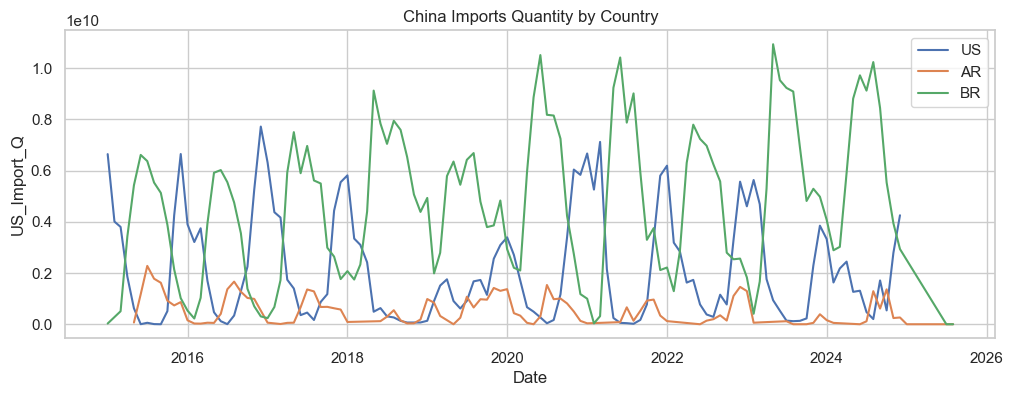

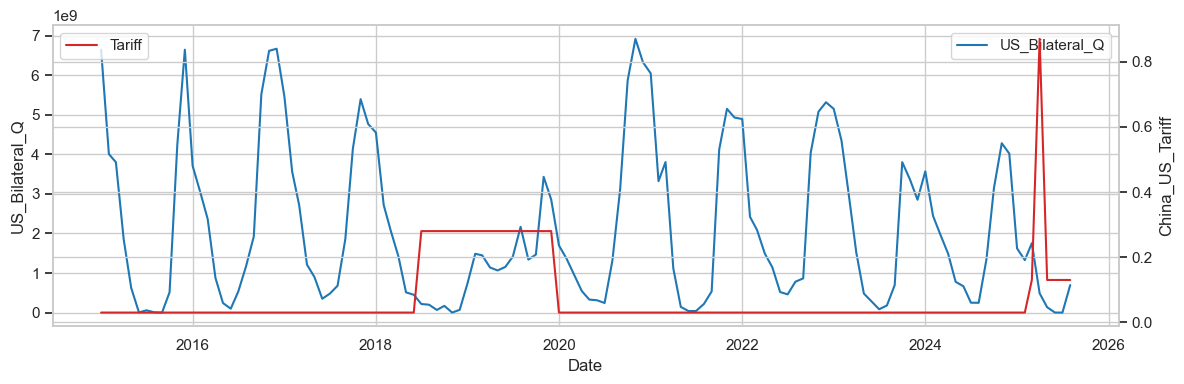

In [28]:
plt.figure(figsize=(12,4))
sns.lineplot(x='Date', y='US_Import_Q', data=import_data, label='US')
sns.lineplot(x='Date', y='AR_Import_Q', data=import_data, label='AR')
sns.lineplot(x='Date', y='BR_Import_Q', data=import_data, label='BR')
plt.title('China Imports Quantity by Country')
plt.show()
fig, ax1 = plt.subplots(figsize=(12,4))
sns.lineplot(x='Date', y='US_Bilateral_Q', data=clean_data, ax=ax1, color='tab:blue', label='US_Bilateral_Q')
ax2 = ax1.twinx()
sns.lineplot(x='Date', y='China_US_Tariff', data=clean_data, ax=ax2, color='tab:red', label='Tariff')
fig.tight_layout()
plt.show()
